In [1]:
!python.exe -m pip install --upgrade pip
!pip install pandas; numpy;  scikit-learn; seaborn; category_encoders; matplotlib;  --quiet
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score,recall_score, f1_score
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold

Defaulting to user installation because normal site-packages is not writeable


# Dataset 

In [2]:
#dataset
dfs = []
for i in range(1,5):
    path = './data/UNSW-NB_complet/UNSW-NB15_{}.csv'  
    dfs.append(pd.read_csv(path.format(i), header = None, low_memory=False))
df = pd.concat(dfs).reset_index(drop=True)

df_col = pd.read_csv('./data/UNSW-NB_complet/NUSW-NB15_features.csv', encoding='ISO-8859-1')
df_col['Name'] = df_col['Name'].apply(lambda x: x.strip().replace(' ', '').lower())

df.columns = df_col['Name']

cols_to_drop_total = [
    'srcip', 'dstip', 'stime', 'ltime',
    'dsport', 'sport',
    'attack_cat',
    'stcpb', 'dtcpb',
    'trans_depth', 'res_bdy_len',
    'is_ftp_login', 'ct_flw_http_mthd', 'ct_ftp_cmd',
    'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm'
]



df.drop(columns=cols_to_drop_total, inplace=True)

#eliminam duplicatele
df = df.drop_duplicates().reset_index(drop=True)
        
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

#verificam ca train si test sunt disjuncte
train_idx = df_train.index
test_idx = df_test.index
common_idx = train_idx.intersection(test_idx)
print(f'Intersectie dupa index: {len(common_idx)} randuri comune')



Intersectie dupa index: 0 randuri comune


In [3]:
print(f'total: {len(df)}')
print(f'normal: {len(df[df["label"] == 0])}')
print(f'atac: {len(df[df["label"] == 1])}')

total: 1697877
normal: 1638975
atac: 58902


# Preprocesare

In [4]:
malign_train = df_train[df_train['label'] == 1]
benign_train = df_train[df_train['label'] == 0]

n = min(len(malign_train), len(benign_train))

malign_train = resample(malign_train, 
                            replace=True, 
                            n_samples=n, 
                            random_state=42)
benign_train = resample(benign_train,
                            replace=True, 
                            n_samples=n, 
                            random_state=42)

df_train = pd.concat([malign_train, benign_train])
df_train = df_train.sample(frac=1, random_state=42).reset_index(drop=True)


malign_test = df_test[df_test['label'] == 1]
benign_test = df_test[df_test['label'] == 0]

n = min(len(malign_test), len(benign_test))

malign_test = resample(malign_test, 
                            replace=True, 
                            n_samples=n, 
                            random_state=42)
benign_test = resample(benign_test,
                            replace=True, 
                            n_samples=n, 
                            random_state=42)

df_test = pd.concat([malign_test, benign_test])
df_test = df_test.sample(frac=1, random_state=42).reset_index(drop=True)



In [5]:
transform_cols = [  'proto', 
                    'state',
                    'service'
                    ]

encoder = TargetEncoder(cols=transform_cols, handle_unknown='value')

df_train_encoded = encoder.fit_transform(df_train[transform_cols], df_train['label'])
df_train_rest = df_train.drop(columns=transform_cols)
df_train = pd.concat([df_train_rest, df_train_encoded], axis=1)

df_test_encoded = encoder.transform(df_test[transform_cols])
df_test_rest = df_test.drop(columns=transform_cols)
df_test = pd.concat([df_test_rest, df_test_encoded], axis=1)

# joblib.dump(encoder, "target_encoder.pkl")

<Axes: xlabel='Name', ylabel='Name'>

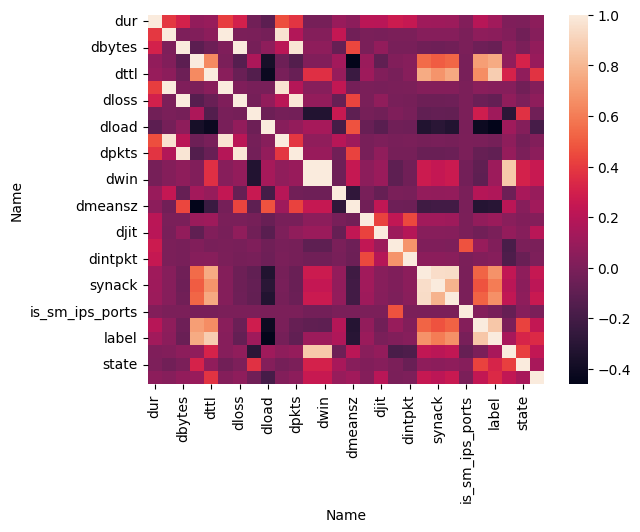

In [6]:
corr_matrix = df_train.corr()
sns.heatmap(corr_matrix, annot=False)

In [7]:
corr_matrix = df_train.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
if 'label' in to_drop:
    to_drop.remove('label')
df_train = df_train.drop(columns=to_drop)
df_test = df_test.drop(columns=to_drop)

### Gini-Weighted Random Forest criterion

In [8]:
X = df_train.drop(columns=['label'])
y = df_train['label']

giwrf = RandomForestClassifier(
    n_estimators=100,          
    class_weight='balanced',   
    random_state=42,
    n_jobs=-1               
)


giwrf.fit(X, y)

feature_importances = pd.Series(giwrf.feature_importances_, index=X.columns)


threshold = 0.02
selected_features_gini = feature_importances[feature_importances > threshold].index.tolist()

df_train = df_train[selected_features_gini + ['label']]
df_test = df_test[selected_features_gini + ['label']]


In [9]:
x_train = df_train.drop(columns=['label'])
y_train = df_train['label']


x_test = df_test.drop(columns=['label'])
y_test = df_test['label']
  
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Antrenare Model

Decision Tree Classification Report:
Accuracy: 0.98
              precision    recall  f1-score   support

           0       0.98      0.99      0.98     12003
           1       0.99      0.98      0.98     12003

    accuracy                           0.98     24006
   macro avg       0.98      0.98      0.98     24006
weighted avg       0.98      0.98      0.98     24006



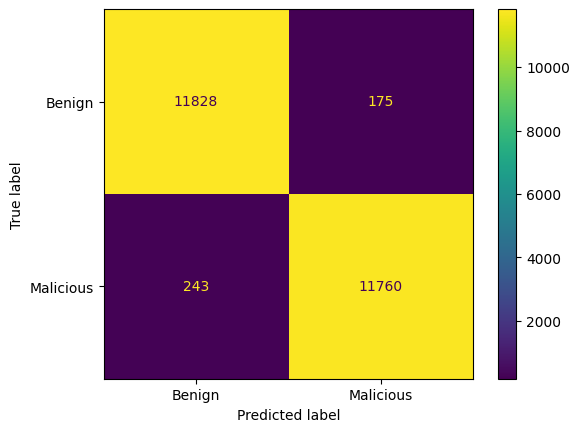

In [10]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(x_train, y_train)

y_pred_dt = dt_model.predict(x_test)


print("Decision Tree Classification Report:")
accuracy = accuracy_score(y_test, y_pred_dt)
print(f"Accuracy: {accuracy:.2f}")
print(classification_report(y_test, y_pred_dt))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt, display_labels=['Benign', 'Malicious'])


# Cross Validation

Acuratete medie pe validare: 0.9886
Deviatie standard: 0.0004

--- Clasa 0 ---
Precizie medie: 0.9901
Recall mediu:    0.9871
F1-score mediu:  0.9886

--- Clasa 1 ---
Precizie medie: 0.9871
Recall mediu:    0.9902
F1-score mediu:  0.9887

Matricea de confuzie medie:
[[9258  121]
 [  92 9287]]


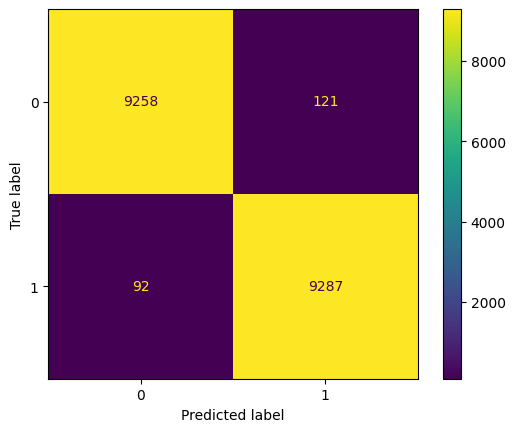

In [11]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

precisions_per_class = []
recalls_per_class = []
f1_scores_per_class = []
conf_matrices = []
accuracies = []

for train_idx, val_idx in kf.split(x_train_scaled, y_train):
    X_train_fold = x_train_scaled[train_idx]
    y_train_fold = y_train.iloc[train_idx]

    X_val_fold = x_train_scaled[val_idx]
    y_val_fold = y_train.iloc[val_idx]

    dt_model = DecisionTreeClassifier(random_state=42)
    dt_model.fit(X_train_fold, y_train_fold)

    y_pred = dt_model.predict(X_val_fold)

    acc = accuracy_score(y_val_fold, y_pred)
    prec = precision_score(y_val_fold, y_pred, average=None, labels=[0, 1])
    rec = recall_score(y_val_fold, y_pred, average=None, labels=[0, 1])
    f1 = f1_score(y_val_fold, y_pred, average=None, labels=[0, 1])
    cm = confusion_matrix(y_val_fold, y_pred)

    accuracies.append(acc)
    precisions_per_class.append(prec)
    recalls_per_class.append(rec)
    f1_scores_per_class.append(f1)
    conf_matrices.append(cm)

# Convertim în array pentru a calcula medii și deviații standard
precisions_per_class = np.array(precisions_per_class)
recalls_per_class = np.array(recalls_per_class)
f1_scores_per_class = np.array(f1_scores_per_class)

print(f"Acuratete medie pe validare: {np.mean(accuracies):.4f}")
print(f"Deviatie standard: {np.std(accuracies):.4f}")

for i, cls in enumerate([0, 1]):
    print(f"\n--- Clasa {cls} ---")
    print(f"Precizie medie: {np.mean(precisions_per_class[:, i]):.4f}")
    print(f"Recall mediu:    {np.mean(recalls_per_class[:, i]):.4f}")
    print(f"F1-score mediu:  {np.mean(f1_scores_per_class[:, i]):.4f}")

# Matricea de confuzie medie
conf_matrix_avg = np.mean(conf_matrices, axis=0).astype(int)
print("\nMatricea de confuzie medie:")
print(conf_matrix_avg)
ConfusionMatrixDisplay(conf_matrix_avg).plot(cmap='viridis')

